In [1]:
import numpy as np #Math function
import matplotlib.pyplot as plt #Plot functions
from scipy import signal as scisig
from mpl_toolkits.mplot3d import Axes3D #3D plot functions
import serial
import time
import re
import os
os.chdir('D:\\Dropbox\\FUS Computer\\') #Set Directory
import sys
sys.path.append('D:\\Dropbox\\FUS Computer\\') # For MotorScan.py
import MotorScan
from MotorScan import movecmd
from picoscope import ps5000a
import MotorScan
from MotorScan import movecmd
%matplotlib inline
import scipy.io as sio
import datetime
import importlib

# Connect motors 
Connect the box to a USB port on the computer and make sure it's powered on

In [3]:
com_port = 'COM3' #Check Com port in device manager. Will change depending on computer and devices already plugged in

motors = MotorScan.MotorsXYZ(com_port, 115200, 5)

motors.open_com()

In [5]:
#This is how to close com for example to free up the port. Don't run this code unless you want to disconnect
motors.close_com()

In [5]:
#open the device. must be plgged into USB
#Be sure to match the device in the code to the one you have plugged in
#ps = ps3000a.PS3000a()
ps = ps5000a.PS5000a()

#### Setup acquisition parameters (this can be done any number of times to change parameters)

In [25]:
#these are the allowed voltage ranges
allowed_voltages = np.array( [.02, .05, .1, .2]) 

def nearest_vrange(arg,return_index=False): #Returns nearest voltage in allowed_voltages
    ii = np.argmin(np.abs(arg-allowed_voltages)).astype(int)
    if return_index:
        return ii
    else:
        return allowed_voltages[ii]

#Set up acquistion from chan A
ps.setChannel(channel='A',coupling='DC',VRange=0.5 )#whatever value that is picoscpe i +- value so that value is 1+ 


#set to 14-bit ADC resolution
ps.setResolution("14")

#set the time between samples and the duration of sampling. 
#returns (actual sample interval, number of samples, the max available samples in general )
(dt, numsamp, junk) = ps.setSamplingInterval(0.3e-6, 10e-3)      # This is what I've been using for 2Ds
#(dt, numsamp, junk) = ps.setSamplingInterval(0.3e-6, 150e-6)    # This is what Tom uses for 3D

Fs = 1.0/dt
#Define a buffer to hold result (optional)
volts = np.zeros([numsamp])

dt, numsamp

(2.96e-07, 33784)

#### Setup triggering parameters (this can be re-run any number of times)

In [26]:
#Set for triggering. For 5242B the source must be 'A','B', or 'External'
# Timeout = 0 means wait indefinitely

delay_sec = 0
delay_samples = round(delay_sec/dt)
#delay_samples = 4000
ps.setSimpleTrigger('A', direction='Rising', threshold_V=0.02, timeout_ms=155, delay=delay_samples)

timebase_us = (np.linspace(0,1.0,numsamp)*numsamp*dt + delay_sec)*1e6 #Create array of times in us for plotting

delay_sec*1e6, delay_samples 

(0.0, 0)

# Setup scan volume

In [32]:

motors.send_wait('G28 X Y Z \r\n') #Send motors home

'ok'

In [31]:
motors.send_wait(movecmd(0,0,0)) #This is the command you will use to move the motors
#Use this command to find the focus of the transducer. Edit x,y, and z to find maximum pressure. 

'ok'

In [85]:

motors.getPos()
#Returns current position. If you found the focus above this will return the coordinates of the focus.
#This command can take a while to run, I normally just keep track with a pen and paper

['ok X:-1.0000,Y:-1.0000,Z:60.0000']


[-1.0, -1.0, -1.0]

In [89]:
#This creates the vertices along each axis that will be turned into a 3D grid.
#Using the position of the focus, set up appropriate arrays
#Ex. Focus is at [10,10,20], you want a 5mm by 5mm by 10mm beammap with 1 0.5mm stepsize and the focus in the center.
#What are your vectors?

xp=np.arange(7.5,12.51,0.5)
yp = np.arange(7.5, 12.51, 0.5)
zp = np.arange(15,25.01 , 0.5)
#*note* if you want to aquire up to a point x you have to put the final position as x+0.01


#If you want to do a 2D scan, set one of the axes to a single value. For example like this:
#The motors will move to the location specified and stay there

#xp = np.array([2])
#yp = np.array([5])
#zp = np.array([0])

### Compute the actual path (doesn't start acquisition yet)

`order` determines the stepping order of the motor axes. Axes `0, 1, 2` correspond to `x, y, z` axes, respectively.
The first element of `order` is the **most frequent** step direction, followed by the second element, then the third.

The output is an array of size `N x 3`, where `N` is the number of points to scan in the volume. The motors will start at `xyzvecs[0]` then go to `xyzvecs[1]`, ...

In [91]:
(nx,ny,nz) = list(map(len,[xp,yp,zp]))
(xyzvecs, flatijk) = MotorScan.create_raster_path(xp, yp, zp, order=(1,2,0), constraint=None)

len(xyzvecs)#function that sweeps thru the vol

550

#### Optional plot of the scan path (don't run it if there are a lot of points)

Text(0.5, 0, 'y')

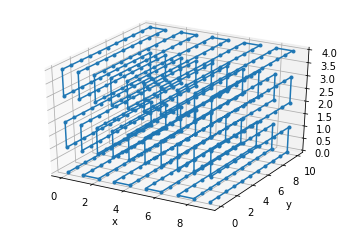

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


plt.plot( xyzvecs[:,0], xyzvecs[:,1], xyzvecs[:,2], '.-')
plt.xlabel('x')
plt.ylabel('y')

## Define acquisition functions

In [93]:
def picoacq(timeout=2.0, numavgs=1, exceptOverflow=True):
    
    avg=np.zeros_like(volts)
    
    for n in range(numavgs):
        ps.flashLed(times=1)
        start_time=time.time()
        ps.runBlock()

        while((time.time() - start_time)<timeout):
            
            if ps.isReady():
                break

        avg += ps.getDataV('A')#, exceptOverflow=exceptOverflow) 
        
    avg/=numavgs
    
    return avg

-0.0026553534366988156

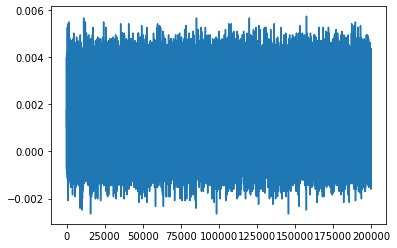

In [93]:
#Test aquisition function. Optional
foo = picoacq()
plt.plot(timebase_us,foo)
min(foo)

## Define function that will be called at every point in the scan volume

In [94]:

#sample_data is a 4D array that holds the beam map. If the scan volume changes, this needs to re-allocated
sample_data = np.zeros([nx,ny,nz,len(volts)])

#if plotting, this sets the number scan points after which a plot will be made
#I do not plot. 
plot_repeat = 108

plot_dir = 'D:\\Malachy\\'
#plot_dir = '' #<-- current directory

def acquire_pico_3D_avg(n, timeout=10.0, do_plot=False, num_avgs=3): #Note that this timeout and num_avgs are different
    (i,j,k)=flatijk[n]
    
    try:
        avg=picoacq(timeout=timeout, numavgs=num_avgs) #The timeout/numavgs set in this function are the ones that matter
    except:
        ii = nearest_vrange(ps.CHRange[0],return_index=True)
        ps.setChannel(channel='A',coupling='DC',VRange=allowed_voltages[ii+1] )
        #ps.setChannel(channel='A',coupling='DC',VRange=0.5 )
        
        avg=picoacq(timeout=timeout, numavgs=num_avgs, exceptOverflow=False)
    
    print("\r"+"%d,%d,%d  "%(i,j,k),end='',flush=True)
 
    sample_data[i,j,k,:]=avg

    if do_plot and (np.mod(n+1, plot_repeat)==0 or n==0):
        
        #YZ plane
        plt.imshow(np.max( np.abs(sample_data[i,:,:]),axis=-1 ),extent=[zp[0],zp[-1],yp[-1],yp[0]], interpolation='none');
        
        #XZ plane
        #plt.imshow(np.max( np.abs(sample_data[:,j,:]),axis=-1 ),extent=[zp[0],zp[-1],xp[-1],xp[0]], interpolation='none');
        
        #XY plane
        #plt.imshow(np.max( np.abs(sample_data[:,:,k]),axis=-1 ).T ,extent=[xp[0],xp[-1],yp[-1],yp[0]], interpolation='none');
        
        #SET AXIS LABELS
        plt.xlabel('y mm')
        plt.ylabel('z mm')
        
        plt.colorbar(label='volts')
        
        #The file name is updated with the k index
        #plt.savefig(plot_dir+'BeamMapSingleFocusAmp20_x=%d.png'%xp[i] ,dpi=300)
        
        plt.savefig('D:\\Malachy\\20220309beammapXY1mm_Probe_TopofTub10%.mat.png',dpi=300)
        
        plt.close()
    
plot_repeat

108

# Ready to run! Almost...

The motor can only make **relative** steps, and the motion controller assumes you are starting at the zero point. 

**SEND THE MOTOR TO HOME POSITION BEFORE STARTING A NEW SCAN:**

In [123]:
#Move back to start
motors.send_wait('G28 X Y Z \r\n') 


'!!'

In [ ]:
#test movement by moving to closest position to transducer. If you look too close stop motors with switch
motors.send_wait(movecd(0,0,0)) #change (0,0,0) to appropriate coordinates

### To test movement without acquiring

### Now to do the actual acquisition

In [121]:
MotorScan.scan_path(motors, xyzvecs, acquisition=acquire_pico_3D_avg, do_plot=False, num_avgs=3, timeout=10) 
#MotorScan.scan_path(motors, xyzvecs) 

(550, 'moves')
9,0,0  =10.0, G1 X0.000000 Y-1.000000 Z0.000000     

If a scan gets interrupted, you can find out what the last index like below. This can be fed back to `scan_path` using `start_n=` keyword.

In [ ]:
data_round = np.round(sample_data,5)
MotorScan.scan_path.last_n

### Now save your data to a matlab file. You can save any variable you want but you will need at least these:

In [122]:
#save matlab file of profiles

variables = {'volts': sample_data, 'xp' : xp, 'yp':yp, 'zp':zp, 
             'dt':dt, 'Ns':numsamp, 'delay_samp':delay_samples}


#scipy.io.savemat('AxialPlane_4pct_Focus_Large.mat', variables)
scipy.io.savemat('D:\\Malachy\\20220411beammap3D1mm_Probe_ConeNEW10%.mat', variables)

In [ ]:
pwd

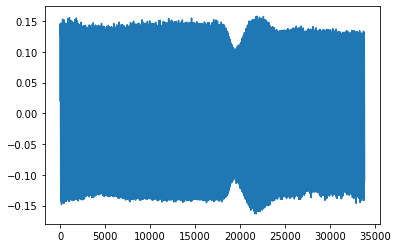

In [39]:
#Test to make sure aquisition worked
plt.plot(sample_data[5,7,0,:])